In [1]:
from geevo.nodes import *
from geevo.graph import Graph2, Graph3
from geevo.simulation import Simulator

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [7]:
cond = "water == 0 and food == 0"

In [12]:
water = 0
food = 0
s = cond.replace("water", str(water))
s = s.replace("food", str(food))
eval(s)

True

In [2]:
conf = {
    Source: 1,
    FixedPoolLimit: 2,
    Converter: 1,
    # Result: 1
    # "FixedPoolLimitConf": [{"lower": 0,}]
}

In [5]:
g = Graph2(config=conf, edge_list=[(0, 1), (1, 3), (3, 2)])

Source-0: [input: [], output: []]
FixedPoolLimit-1: [input: [], output: []]
FixedPoolLimit-2: [input: [], output: []]
Converter-3: [input: [], output: []]
{(0, 1): 1, (1, 3): 1, (3, 2): 1}


C:\Users\flori\Documents\Coding\GEEvo-game-economies\geevo\graph.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


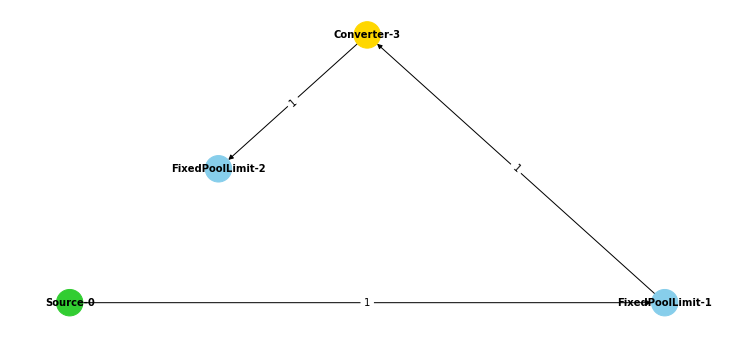

In [3]:
s_in = StateConnectionPoolRegister(variable_name="a", output_pool_id=2, register_input_id=0)
s_out = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(0,1), modifier=10)
r = Register(condition="a > 2")
r.add_input(s_in)
r.add_output(s_out)

g3 = Graph3(config=conf, edge_list=[(0, 1), (1, 3), (3, 2)], weights=[1, 1, 1], registers=[r])
g3.plot()

In [7]:
r.output_state_connection[0]

In [8]:
g3.registers

In [12]:
g3.simulate(20)

Eval cond: 1 > 2 False
Eval cond: 2 > 2 False
Eval cond: 3 > 2 True
Eval cond: 4 > 2 True
Eval cond: 5 > 2 True
Eval cond: 6 > 2 True
Eval cond: 7 > 2 True
Eval cond: 8 > 2 True
Eval cond: 9 > 2 True
Eval cond: 10 > 2 True
Eval cond: 11 > 2 True
Eval cond: 12 > 2 True
Eval cond: 13 > 2 True
Eval cond: 14 > 2 True
Eval cond: 15 > 2 True
Eval cond: 16 > 2 True
Eval cond: 17 > 2 True
Eval cond: 18 > 2 True
Eval cond: 19 > 2 True
Eval cond: 20 > 2 True


{<geevo.nodes.FixedPoolLimit at 0x253a3015f90>: [0,
  0,
  0,
  9,
  18,
  27,
  36,
  45,
  54,
  63,
  72,
  81,
  90,
  99,
  99,
  99,
  99,
  99,
  99,
  99],
 <geevo.nodes.FixedPoolLimit at 0x253a3014d00>: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20]}

# The NMMO Economy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{(0, 9): 1, (0, 10): 1, (1, 2): 0, (2, 11): 0, (3, 12): 10, (4, 8): 1, (4, 14): 1, (5, 13): 10, (6, 3): 100, (7, 4): 2, (8, 5): 100, (9, 7): 0.06, (9, 15): 0.94, (10, 6): 0.74, (10, 16): 0.26}


C:\Users\flori\Documents\Coding\GEEvo-game-economies\geevo\graph.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


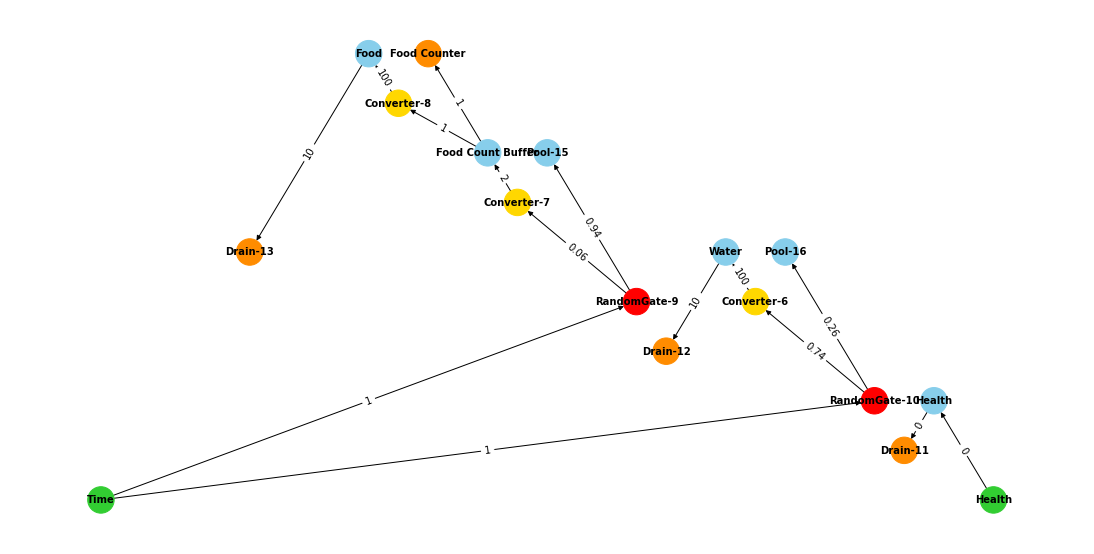

In [2]:
from geevo.nodes import *
from geevo.graph import Graph2, Graph3
from geevo.simulation import Simulator

%load_ext autoreload
%autoreload 2

%matplotlib inline

conf = {
    Source: 2,          # 0, 1
    FixedPoolLimit: 4,  # 2, 3, 4, 5
    Converter: 3,       # 6, 7, 8
    RandomGate: 2,      # 9, 10
    Drain: 4,           # 11, 12, 13, 14
    Pool: 2             # 15, 16
}
# pool-2: health
# pool-3: water
# pool-4: count buffer food
# pool-5: food counter --> not implemented
# pool-6: food


edge_list = [(0, 9), (0, 10), (1, 2), # sources
             (2, 11),    (3, 12), (4, 8), (4, 14), (5, 13), # pools1
             (9, 7), (9, 15), (10, 6), (10, 16), # random gates
             (6, 3), (7, 4) ,(8, 5) # converters
             ] 

s_in_food = StateConnectionPoolRegister(variable_name="food", output_pool_id=5, register_input_id=0)
s_in_water = StateConnectionPoolRegister(variable_name="water", output_pool_id=3, register_input_id=0)
s_out_health_regain = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(1, 2), modifier=10)
regain_health_register = Register(condition="water > 0 and food > 0", name="Regain Health Register")
regain_health_register.add_input(s_in_food)
regain_health_register.add_input(s_in_water)
regain_health_register.add_output(s_out_health_regain)


s_in_food = StateConnectionPoolRegister(variable_name="food", output_pool_id=5, register_input_id=0)
s_in_water = StateConnectionPoolRegister(variable_name="water", output_pool_id=3, register_input_id=0)
s_out_health_drop = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(2, 11), modifier=10)
lose_health_register = Register(condition="water == 0 or food == 0", name="Lose Health Register")
lose_health_register.add_input(s_in_food)
lose_health_register.add_input(s_in_water)
lose_health_register.add_output(s_out_health_drop)

# end condition


weights = [1,1,0, # sources
           0,10,1,1,10, # pools  
           0.06, 0.94, 0.74,0.26, # random gates
           100, 2, 100] # converters

g3 = Graph3(config=conf, edge_list=edge_list, weights=weights, registers=[regain_health_register, lose_health_register])
# Sources
g3.nodes[0].name = "Time"
g3.nodes[1].name = "Health"

# Pools
g3.nodes[2].name = "Health"
g3.nodes[2].pool = 100
g3.nodes[3].name = "Water"
g3.nodes[3].pool = 100
g3.nodes[4].name = "Food Count Buffer"
g3.nodes[5].name = "Food"
g3.nodes[5].pool = 100
g3.nodes[14].name = "Food Counter"

g3.plot(figsize=(15, 7.5))

win_cond = EndCondition(g3.nodes[14], 14, "Food Counter >= 5", WinStates.PLAYER_WINS)
loose_cond = EndCondition(g3.nodes[2], 2, "Health <= 0", WinStates.PLAYER_LOST)

In [5]:
loose_cond.evaluate()

0 <= 0


0

In [14]:
g3.nodes[2].name

'Health'

In [4]:
g3.nodes[2].pool = 0

In [16]:
res = g3.simulate(25)
for node, data in res.items():
    if isinstance(node, FixedPoolLimit):
        print(node.name, data)
    if node.name == "Food Counter":
        print(node.name, data)


Health [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 90, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Water [90, 80, 70, 90, 90, 80, 70, 90, 90, 80, 90, 80, 90, 90, 90, 90, 90, 90, 80, 90, 90, 90, 80, 90, 80]
Food Count Buffer [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Food [90, 80, 70, 60, 50, 40, 30, 20, 10, 0, 90, 80, 70, 60, 50, 40, 30, 20, 10, 90, 90, 80, 70, 60, 50]
Food Counter [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3]


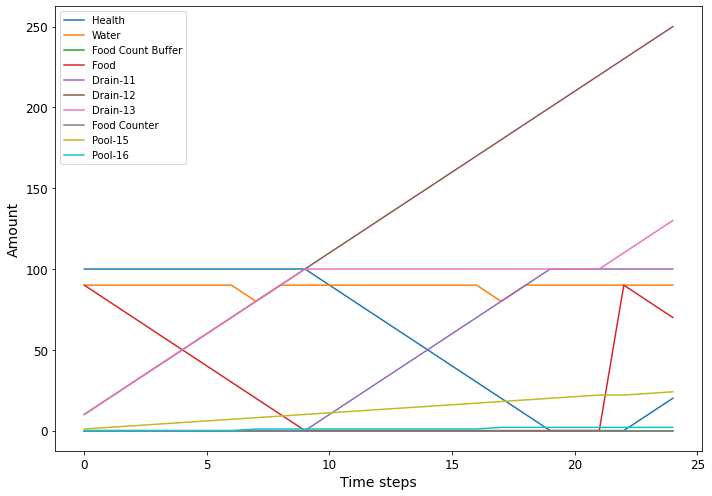

In [8]:
g3.simulator.plot_monitor(drains=True)

{(0, 9): 1, (0, 10): 1, (1, 2): 0, (2, 11): 0, (3, 12): 10, (4, 8): 1, (4, 14): 1, (5, 13): 10, (6, 3): 100, (7, 4): 1, (8, 5): 100, (9, 7): 0.06, (9, 15): 0.94, (10, 6): 0.74, (10, 16): 0.26}


C:\Users\flori\Documents\Coding\GEEvo-game-economies\geevo\graph.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


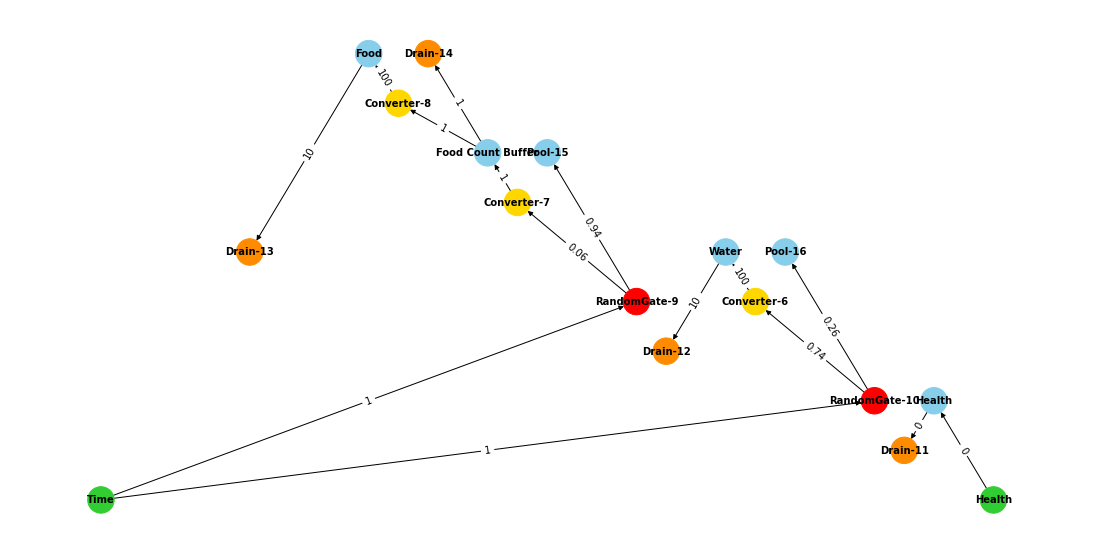

In [5]:
g3.plot(figsize=(15, 7.5))